## Laptop Price Prediction

In [1]:
# Set Parameters


In [2]:
# Import Modules
import re
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import clear_output


#### Get Dataset from Kaggle

In [3]:
# Download Dataset
!mkdir dataset
%cd dataset
!kaggle datasets download -d muhammetvarl/laptop-price
clear_output()


In [4]:
# Unzip Dataset
!tar -xf laptop-price.zip


In [5]:
# Delete Unwanted Files
!del laptop-price.zip
%cd ..
clear_output()


#### Loading Data in Pandas Dataframe

In [6]:
data_df = pd.read_csv('dataset/laptop_price.csv', index_col='laptop_ID', encoding='latin-1')
data_df = data_df.drop(columns=['Product'])


In [7]:
# Check Missing Values
print(f'Dataset has {data_df.isnull().sum().sum()} missing values')

# Check Duplicate Data
print(f'Dataset has {data_df.duplicated().sum()} duplicate records')


Dataset has 0 missing values
Dataset has 29 duplicate records


In [8]:
# Remove Duplicate Records
data_df = data_df.drop_duplicates()


#### Feature Extraction

In [9]:
# View Dataframe
data_df


,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
laptop_ID,,,,,,,,,,,
1,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
2,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
3,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
4,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
5,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60
...,...,...,...,...,...,...,...,...,...,...,...
1287,Asus,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,4GB,500GB HDD,Nvidia GeForce 920M,Windows 10,2.2kg,720.32
1288,Lenovo,2 in 1 Convertible,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,638.00
1289,Lenovo,2 in 1 Convertible,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 520,Windows 10,1.3kg,1499.00


Creating Column for TouchScreen, which is True if Laptop has Touch Screen, False otherwise

In [10]:
data_df['Touch Screen'] = data_df['ScreenResolution'].apply(lambda x: 'touchscreen' in x.lower())


Creating Column for IPS Panel, which is True if Laptop has IPS Panel Screen, False otherwise

In [11]:
data_df['IPS Panel'] = data_df['ScreenResolution'].apply(lambda x: 'IPS' in x)


Extracting Pixels as ints in Width and Height

In [12]:
# Screen Resolution in '/d+x/d+' form
data_df['ScreenResolution'] = data_df['ScreenResolution'].apply(lambda x: re.findall('\d+x\d+', x)[0])

# Pixels in Width and Height
data_df[['X_pixels', 'Y_pixels']] = data_df.apply(lambda x: x['ScreenResolution'].split('x'), axis=1, result_type='expand').astype('int32')

# Dropping Screen Resolution (it became redundant)
data_df = data_df.drop(columns=['ScreenResolution'])


Extracting CPU Type

In [13]:
def extract_CPUtype(text):
    text = text.lower()

    # 3 Types of Intel CPUs [i3, i5, i7]
    if 'intel' in text:
        if 'core i3' in text:
            return 'Intel Core i3'
        elif 'core i5' in text:
            return 'Intel Core i5'
        elif 'core i7' in text:
            return 'Intel Core i7'
        else:
            return 'Intel Other'

    # AMD CPUs
    elif 'amd' in text:
        return 'AMD'

    # Other CPUs
    else:
        return 'Other'


data_df['Cpu'] = data_df['Cpu'].apply(lambda x: extract_CPUtype(x))


Extracting RAM as int in GB

In [14]:
data_df['Ram'] = data_df['Ram'].apply(lambda x: x.replace('GB', '')).astype('int32')


Extracting Storage Capacity

In [15]:
def extract_storage_capacity(text):
    # Change 'Flash Storage' to 'Flash_Storage'
    text = text.replace('Flash Storage', 'Flash_Storage')

    # Different Storage types are sepatated by + symbol
    text = text.split('+')
    text = [x.strip() for x in text]

    storage = {}
    for word in text:
        capacity, storage_type = word.split()

        # Get Capacity in int
        capacity = capacity.replace('.0', '')
        capacity = capacity.replace('GB', '')
        capacity = capacity.replace('TB', '000')
        capacity = int(capacity)

        storage[storage_type] = capacity

    return storage


storage_df = data_df.apply(lambda x: extract_storage_capacity(x['Memory']), axis=1, result_type='expand')
storage_df = storage_df.fillna(0).astype('int32')

data_df = pd.concat([data_df, storage_df], axis=1)

# Dropping Memory (it became redundant)
data_df = data_df.drop(columns=['Memory'])


Extracting GPU Type

In [16]:
data_df['Gpu'] = data_df['Gpu'].apply(lambda x: x.split()[0])


Extracting Operating System Type

In [17]:
def extract_operating_system(text):
    text = text.lower()

    if 'windows' in text:
        return 'Windows'
    elif 'mac' in text:
        return 'MAC'
    else:
        return 'Other'


data_df['OpSys'] = data_df['OpSys'].apply(lambda x: extract_operating_system(x))


Extracting Weight as int in kg

In [18]:
data_df['Weight'] = data_df['Weight'].apply(lambda x: x.replace('kg', '')).astype('float32')


In [19]:
# View Dataframe
data_df


,Company,TypeName,Inches,Cpu,Ram,Gpu,OpSys,Weight,Price_euros,Touch Screen,IPS Panel,X_pixels,Y_pixels,SSD,Flash_Storage,HDD,Hybrid
laptop_ID,,,,,,,,,,,,,,,,,
1,Apple,Ultrabook,13.3,Intel Core i5,8,Intel,MAC,1.37,1339.69,False,True,2560,1600,128,0,0,0
2,Apple,Ultrabook,13.3,Intel Core i5,8,Intel,MAC,1.34,898.94,False,False,1440,900,0,128,0,0
3,HP,Notebook,15.6,Intel Core i5,8,Intel,Other,1.86,575.00,False,False,1920,1080,256,0,0,0
4,Apple,Ultrabook,15.4,Intel Core i7,16,AMD,MAC,1.83,2537.45,False,True,2880,1800,512,0,0,0
5,Apple,Ultrabook,13.3,Intel Core i5,8,Intel,MAC,1.37,1803.60,False,True,2560,1600,256,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,Asus,Notebook,15.6,Intel Core i7,4,Nvidia,Windows,2.20,720.32,False,False,1366,768,0,0,500,0
1288,Lenovo,2 in 1 Convertible,14.0,Intel Core i7,4,Intel,Windows,1.80,638.00,True,True,1920,1080,128,0,0,0
1289,Lenovo,2 in 1 Convertible,13.3,Intel Core i7,16,Intel,Windows,1.30,1499.00,True,True,3200,1800,512,0,0,0


#### Data Visualization

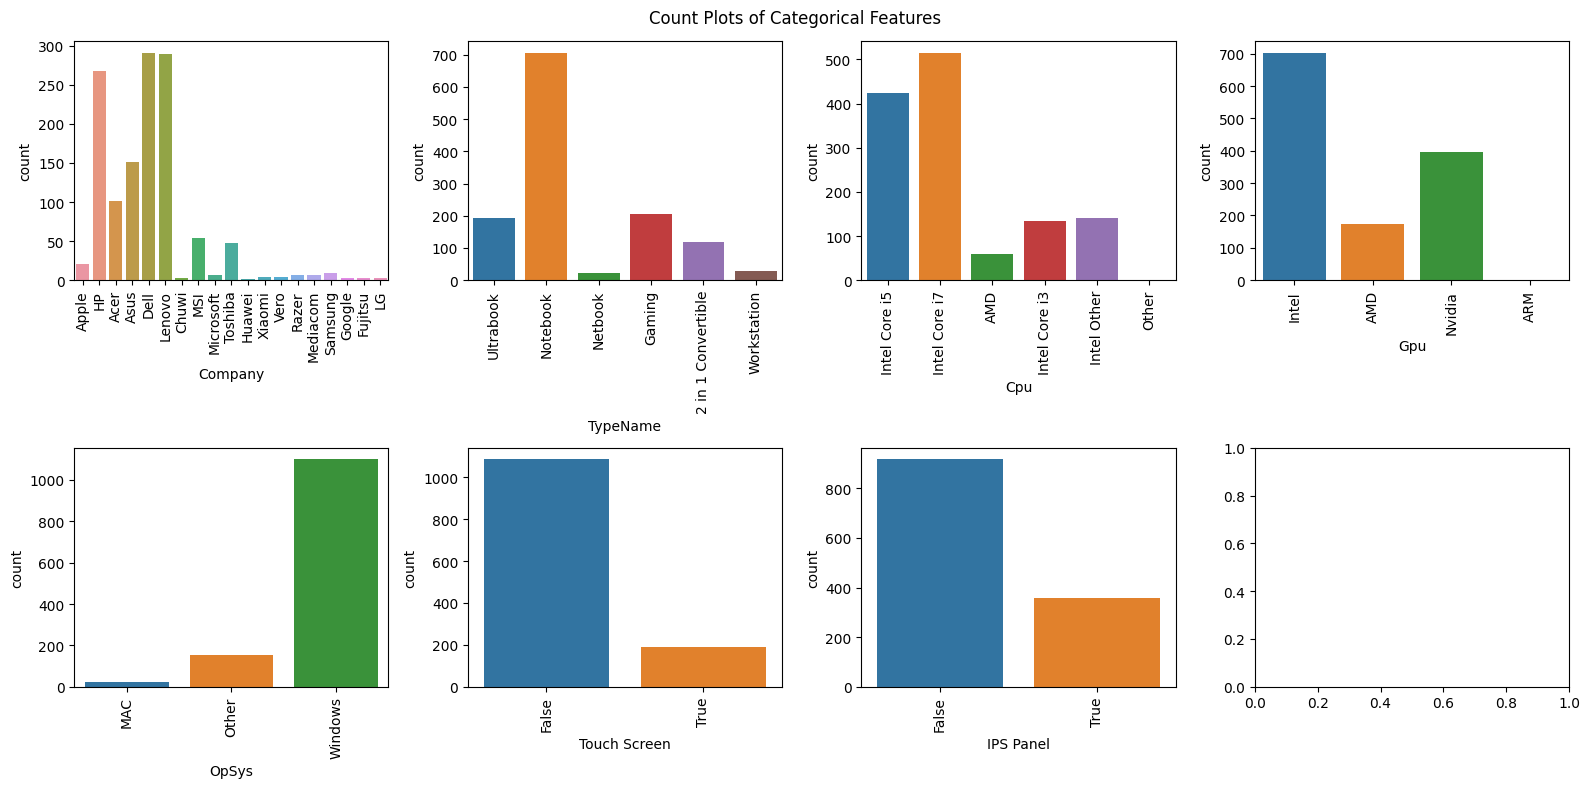

In [20]:
# Count Plot of Categorical Features
categorical_features = data_df.select_dtypes(include=['object', 'bool']).columns

fig, ax = plt.subplots(math.ceil(len(categorical_features)/4), 4, figsize=(16, 8))
fig.suptitle('Count Plots of Categorical Features')

for i, feature in enumerate(categorical_features):
    sns.countplot(data_df, x=feature, ax=ax[i//4][i % 4], palette=None)
    ax[i//4][i % 4].tick_params(axis='x', labelrotation=90)

fig.tight_layout()


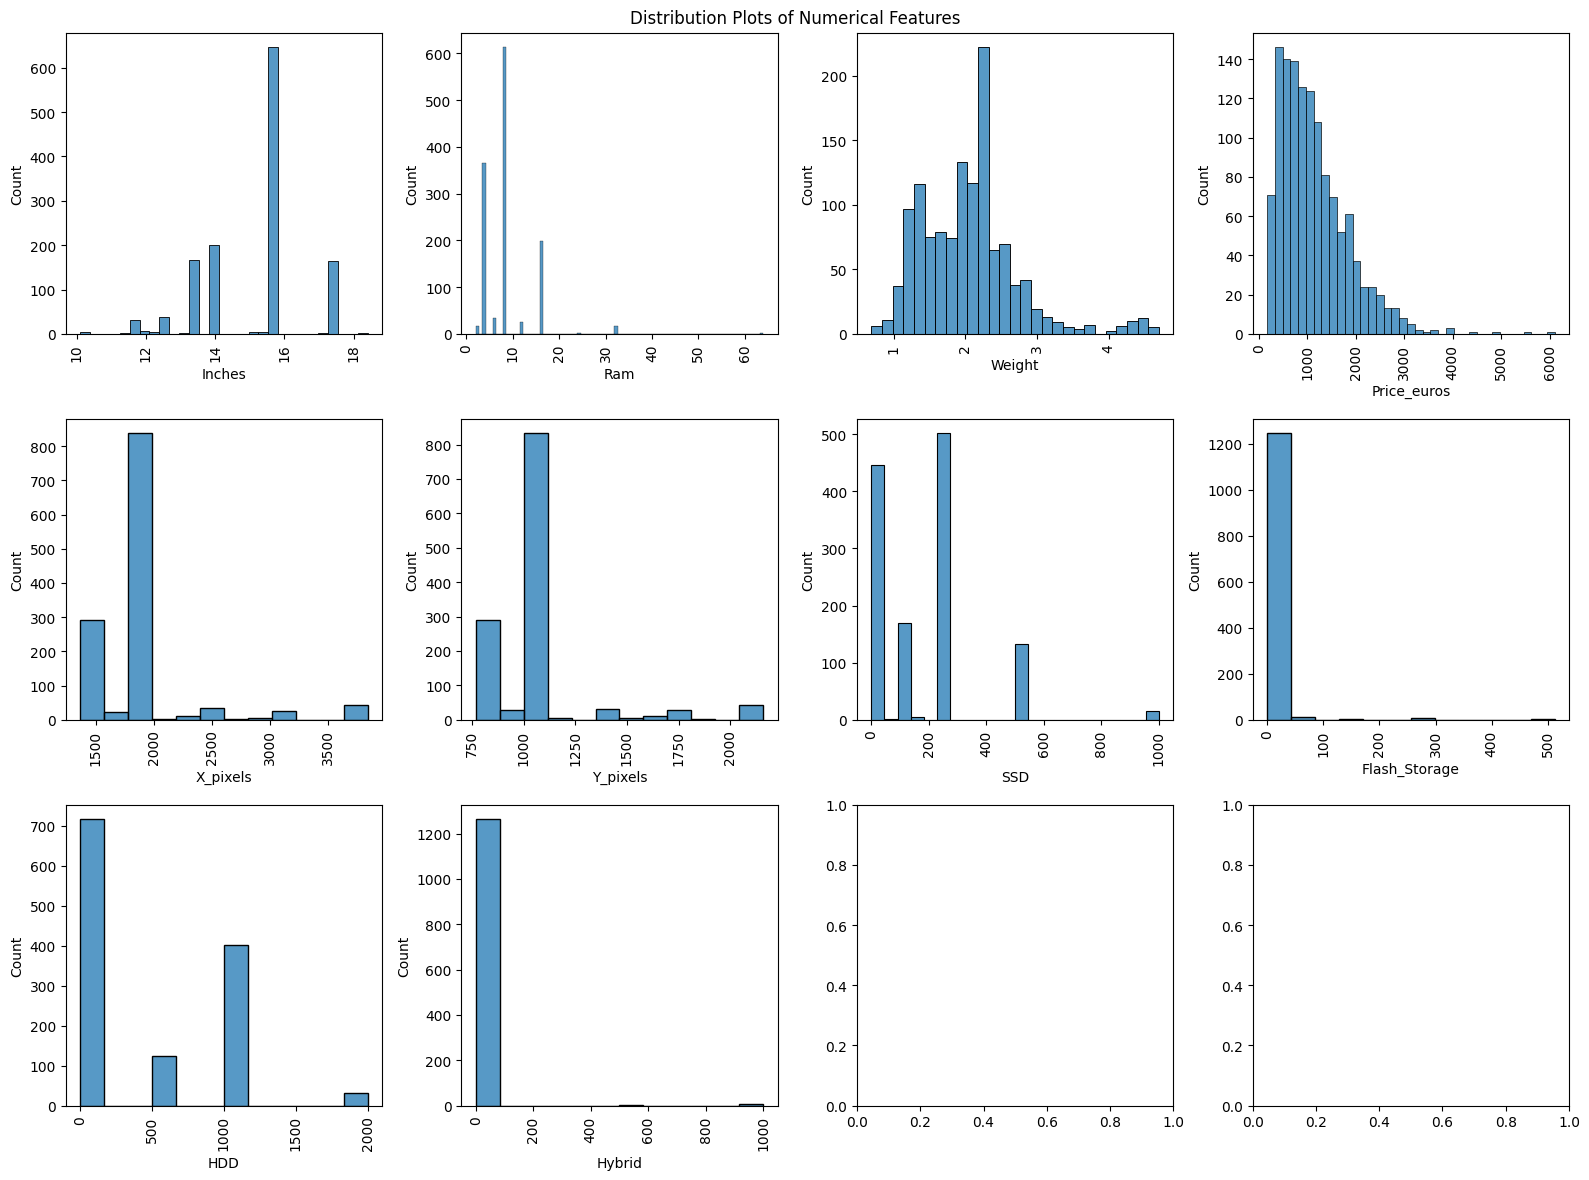

In [21]:
# Distribution Plot of Numerical Features
numerical_features = data_df.select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns

fig, ax = plt.subplots(math.ceil(len(numerical_features)/4), 4, figsize=(16, 12))
fig.suptitle('Distribution Plots of Numerical Features')

for i, feature in enumerate(numerical_features):
    sns.histplot(data_df, x=feature, ax=ax[i//4][i % 4], palette=None)
    ax[i//4][i % 4].tick_params(axis='x', labelrotation=90)

fig.tight_layout()


In [22]:
# Check Count for CPU
data_df['Cpu'].value_counts()


Cpu
Intel Core i7    515
Intel Core i5    423
Intel Other      141
Intel Core i3    134
AMD               60
Other              1
Name: count, dtype: int64

In [23]:
# Removing the only Sample with Other CPU
data_df = data_df[data_df['Cpu'] != 'Other']


In [24]:
# Check Count for GPU
data_df['Gpu'].value_counts()


Gpu
Intel     703
Nvidia    396
AMD       174
Name: count, dtype: int64